In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/Dataset/lung/train"
test_path = "/content/drive/MyDrive/Dataset/lung/test"
valid_path = "/content/drive/MyDrive/Dataset/lung/val"

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(32, 32), batch_size=12, class_mode='categorical')

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(32, 32), batch_size=12, class_mode='categorical')

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(32, 32), batch_size=5, shuffle=False, class_mode='categorical')

Found 6328 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model input
inputs = tf.keras.Input(shape=(32, 32, 3))

# First convolutional block
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
residual = layers.Conv2D(32, kernel_size=(1, 1), strides=(2, 2), padding='same')(x)

# Second convolutional block
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)

# Adjust spatial dimensions of residual to match 'x'
residual = layers.Conv2D(64, kernel_size=(1, 1), padding='same')(residual)
residual = layers.UpSampling2D(size=(2, 2))(residual)

# Add residual connection
x = layers.Add()([x, residual])

# Third convolutional block
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)

# Flatten and fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)  # Change to 4 units for 4 classes

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Define the optimizer with the learning rate
optimizer = tf.keras.optimizers.Adam()  # Create an instance of the Adam optimizer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # Pass the optimizer instance here

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 32)     │          1,056 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 131072)         │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     33,554,688 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │          1,028 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,845,892 (129.11 MB)

 Trainable params: 33,845,892 (129.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 32)     │          1,056 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 131072)         │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     33,554,688 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │          1,028 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,845,892 (129.11 MB)

 Trainable params: 33,845,892 (129.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Initialize callbacks
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 6, verbose = 1)
mc = ModelCheckpoint(filepath = 'lung_disease_detector.keras', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto')

# Define the callbacks list
cb = [mc, es]

In [ ]:
history = model.fit(x=train_batches,
                    validation_data=valid_batches,
                    callbacks = cb,
                    epochs=23)

Epoch 1/23


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8257 - loss: 0.5700
Epoch 1: val_accuracy improved from -inf to 0.68421, saving model to lung_disease_detector.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 1915s 3s/step - accuracy: 0.8258 - loss: 0.5696 - val_accuracy: 0.6842 - val_loss: 3.7381
Epoch 2/23
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9336 - loss: 0.1868
Epoch 2: val_accuracy improved from 0.68421 to 0.76316, saving model to lung_disease_detector.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 699s 1s/step - accuracy: 0.9336 - loss: 0.1868 - val_accuracy: 0.7632 - val_loss: 0.6457
Epoch 3/23
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9494 - loss: 0.1442
Epoch 3: val_accuracy improved from 0.76316 to 0.81579, saving model to lung_disease_detector.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.9494 - loss: 0.1442 - val_accuracy: 0.8158 - val_loss: 0.4092
Epoch 4/23
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9689 - loss: 0.0959
Epoch 4: val_accura

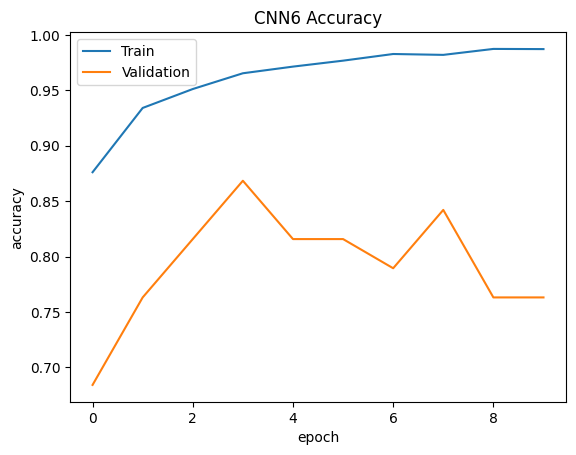

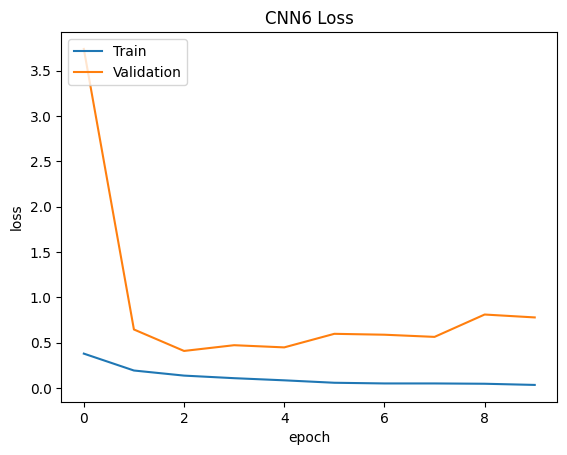

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN6 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN6 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# load model, use the correct filename
model1 = load_model('lung_disease_detector.keras')

In [ ]:
test_labels = test_batches.classes
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
pred = model1.predict(x=test_batches)

155/155 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step


In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=pred.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

In [ ]:
def plot_cm(cm, classes,
            normalize=False, title='Confusion Matrix',
            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment = 'center', color = "white" if cm[i,j]> thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalization
[[ 93   1   2  10]
 [ 10 104 110  10]
 [  1   6 383   0]
 [  1   0   0  40]]


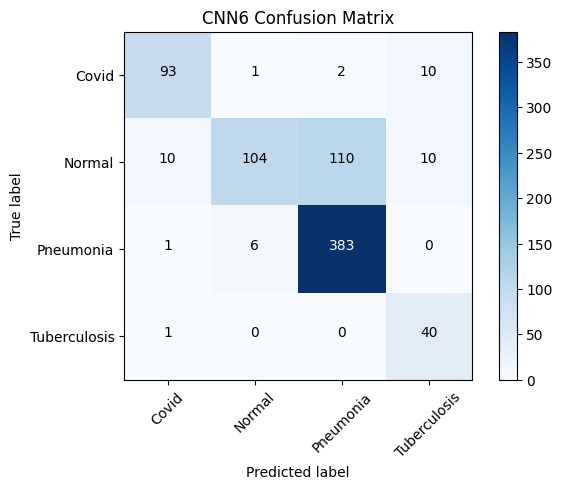

In [ ]:
cm_plot_labels=["Covid", "Normal","Pneumonia","Tuberculosis"]
plot_cm(cm=cm, classes=cm_plot_labels, title = 'CNN6 Confusion Matrix')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print("CNN6 Classification Report: \n", classification_report(y_true=test_labels, y_pred=pred.argmax(axis=1)))

CNN6 Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       106
           1       0.94      0.44      0.60       234
           2       0.77      0.98      0.87       390
           3       0.67      0.98      0.79        41

    accuracy                           0.80       771
   macro avg       0.82      0.82      0.79       771
weighted avg       0.83      0.80      0.78       771



In [ ]:
from sklearn.metrics import accuracy_score

print(100*accuracy_score(test_labels, pred.argmax(axis=1)))

80.41504539559014


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load ResNet50 base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer_resnet = Dense(4, activation='softmax')(x)

# Create model
model_resnet50 = Model(inputs=resnet_base.input, outputs=output_layer_resnet)

# Compile ResNet50 model
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example of loading images from a directory
train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/lung/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load and preprocess validation data
validation_datagen = ImageDataGenerator(rescale=1./255)  # You may want to apply the same preprocessing as the training data
validation_data = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/lung/val',  # Replace with the path to your validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Assuming you have already prepared train_data and validation_data
history_resnet50 = model_resnet50.fit(train_data, validation_data=validation_data, epochs=10)

Found 6328 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 2625s 12s/step - accuracy: 0.8389 - loss: 0.4107 - val_accuracy: 0.3158 - val_loss: 10.2186
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 104s 508ms/step - accuracy: 0.9845 - loss: 0.0516 - val_accuracy: 0.3158 - val_loss: 5.3861
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 138s 490ms/step - accuracy: 0.9854 - loss: 0.0390 - val_accuracy: 0.3158 - val_loss: 11.2154
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 102s 498ms/step - accuracy: 0.9916 - loss: 0.0283 - val_accuracy: 0.5263 - val_loss: 2.5803
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 493ms/step - accuracy: 0.9947 - loss: 0.0214 - val_accuracy: 0.7632 - val_loss: 0.6927
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 143s 497ms/step - accuracy: 0.9920 - loss: 0.0283 - val_accuracy: 0.9737 - val_loss: 0.1191
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 100s 492ms/step - accuracy: 0.9962 - loss: 0.0139 - val_accuracy: 0.9737 - val_loss: 0.0750
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 492ms/step - accuracy: 0.9970 - loss: 0.0

In [1]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_resnet50.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


NameError: name 'model_resnet50' is not defined

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions on the test data
y_pred = model_resnet50.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Assuming test_labels is the true labels of the test dataset
y_true = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
